<a href="https://colab.research.google.com/github/Veron28/bot_test/blob/master/rrr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">Cryptocurrency Price Prediction by Data Secrets</font></b>


<b><font color="black" size="+2">Colab created by:</font></b>

Telegram: [@DataSecrets](https://t.me/+DuwnB6pn4UYwM2I6)

```
Чтобы получить результат, поочередно нажимайте на запуск ячеек, дожидаясь завершения выполнения каждого блока.
```

**В этой статье мы расскажем о прогнозировании цен на криптовалюту с помощью машинного обучения и Python.**

Сначала установим все необходимые библиотеки. 

In [ ]:
!pip install yfinance
!pip install autots
!pip install prophet

<h2>А что с данными?</h2>

**Для этой задачи мы соберем последние данные о ценах на биткойны из Yahoo Finance, используя API yfinance.**



In [ ]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
import matplotlib as plt
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=730)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('BTC-USD', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-10-14 00:00:00+00:00,11429.047852,11539.977539,11307.831055,11429.506836,11429.506836,24103426719
1,2020-10-15 00:00:00+00:00,11426.602539,11569.914062,11303.603516,11495.349609,11495.349609,24487233058
2,2020-10-16 00:00:00+00:00,11502.828125,11540.061523,11223.012695,11322.123047,11322.123047,25635480772
3,2020-10-17 00:00:00+00:00,11322.123047,11386.261719,11285.345703,11358.101562,11358.101562,19130430174
4,2020-10-18 00:00:00+00:00,11355.982422,11483.359375,11347.578125,11483.359375,11483.359375,18283314340


Теперь давай визуализируем изменение цен на биткойны до сегодняшнего дня:

In [ ]:
import plotly.graph_objects as go
figure = go.Figure(data=[go.Candlestick(x=data["Date"],
                                        open=data["Open"], 
                                        high=data["High"],
                                        low=data["Low"], 
                                        close=data["Close"])])
figure.update_layout(title = "Bitcoin Price Analysis", 
                     xaxis_rangeslider_visible=False)
figure.show()

**Данные, которые необходимо предсказывать, находятся в столбце Close. Тогда оценим корреляцию всех столбцов в данных с этим столбцом:**

In [ ]:
correlation = data.corr()
print(correlation["Close"].sort_values(ascending=False))

Close        1.000000
Adj Close    1.000000
High         0.997319
Low          0.996899
Open         0.993945
Volume       0.232616
Name: Close, dtype: float64


<h2>Предсказания</h2>

**Для предсказаний будем пользоваться библиотекой Prophet (про нее мы уже тебе рассказывали).**

In [ ]:
from prophet import Prophet

**Включим в рассмотрение сезонность по неделям и месяцам, и отключим дневную сезонность.**

In [ ]:
data_prophet = pd.DataFrame()
data_prophet['ds'] = data['Date'].dt.date
data_prophet['y'] = data['Close']
model = Prophet(daily_seasonality=False)
model.fit(data_prophet)

**Сделаем прогноз. Библиотека позволяет помимо точечного прогноза увидеть еще кучу полезного, например границы доверительный интервалов. Посмотрим, что тут есть:**

In [ ]:
future = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-10-14,7269.244771,921.041026,13322.451181,7269.244771,7269.244771,132.909822,132.909822,132.909822,132.909822,132.909822,132.909822,0.0,0.0,0.0,7402.154592
1,2020-10-15,7574.033264,784.896034,13336.232598,7574.033264,7574.033264,-9.570301,-9.570301,-9.570301,-9.570301,-9.570301,-9.570301,0.0,0.0,0.0,7564.462963
2,2020-10-16,7878.821757,1282.798181,13828.792743,7878.821757,7878.821757,-57.997274,-57.997274,-57.997274,-57.997274,-57.997274,-57.997274,0.0,0.0,0.0,7820.824483
3,2020-10-17,8183.610251,2048.639480,13950.780963,8183.610251,8183.610251,-20.394736,-20.394736,-20.394736,-20.394736,-20.394736,-20.394736,0.0,0.0,0.0,8163.215514
4,2020-10-18,8488.398744,2001.476758,14586.498040,8488.398744,8488.398744,-3.639064,-3.639064,-3.639064,-3.639064,-3.639064,-3.639064,0.0,0.0,0.0,8484.759680


**А вот и самое интересное: прогноз на месяц.**

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
730,2022-10-14,14575.846703,8248.078209,20632.998899
731,2022-10-15,14495.677595,7736.965338,20386.522260
732,2022-10-16,14394.661621,7607.163680,20355.784506
733,2022-10-17,14288.175207,7906.463462,20940.682491
734,2022-10-18,14113.802780,8008.205138,20138.722700
735,2022-10-19,14177.895570,8142.353958,20447.981647
736,2022-10-20,13917.643802,7654.235911,20412.084306
737,2022-10-21,13751.445182,7758.248531,19916.832779
738,2022-10-22,13671.276075,7007.262663,19831.052887
739,2022-10-23,13570.260101,7356.848732,20103.895727


**Визуализируем предсказания:**

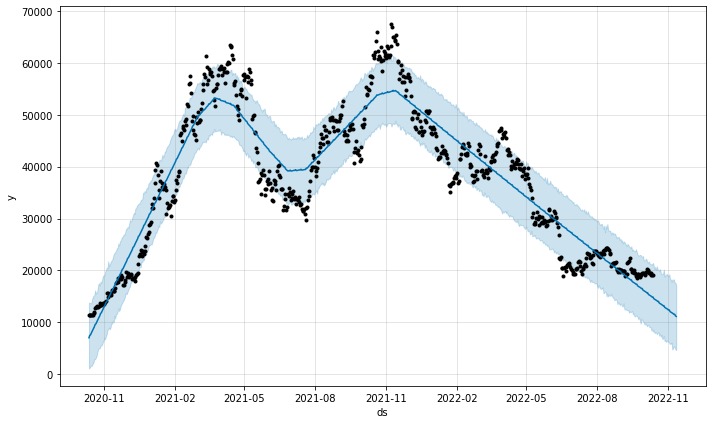

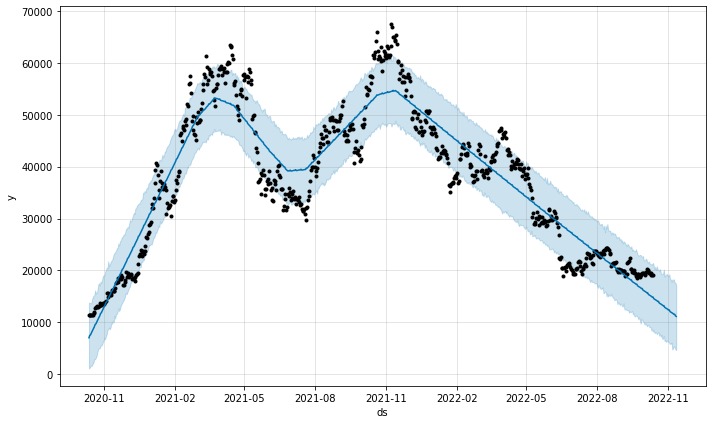

In [ ]:
model.plot(forecast)

**Так как мы всегда загружаем актуальные данные, в любой момент, когда ты будешь запускать этот ноутбук, прогноз будет давать новый прогноз на новый месяц.** 

**Пользуйся, не благодари :)** 